## Accessing NRCAN Landcover data with the Planetary Computer STAC API

[National Resources Canada (NRCAN) Landcover](https://www.nrcan.gc.ca/maps-tools-publications/satellite-imagery-air-photos/application-development/land-cover/21755) is derived from cloud-free mosaics from thousands of satellite images collected in the short summer months when snow and ice cover is lowest. Advanced machine learning techniques and complex algorithms developed and verified through fieldwork are used to identify land cover types within the images. The result is a collection of continental, national scale and regional land cover products encompassing different time periods and frequencies, and at different spatial resolutions. 

In this notebook, we'll demonstrate how to access and work with this data through the Planetary Computer.

Complete documentation for this dataset is available on the [Planetary Computer data catalog](https://planetarycomputer-staging.microsoft.com/dataset/nrcan-landcover_).

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from dask.distributed import Client as dask_client
from matplotlib.colors import ListedColormap
from pystac_client import Client
from pystac.extensions.raster import RasterExtension as raster
from pystac.extensions.projection import ProjectionExtension as proj

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer as pc
import rasterio
import rasterio.features
import stackstac

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Select a region and find data items

We'll pick an area surrounding Vancouver and use the STAC API to find what data items are available.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-124.134521484375, 49.00724918431423],
            [-121.75872802734375, 49.00724918431423],
            [-121.75872802734375, 50.07300647938297],
            [-124.134521484375, 50.07300647938297],
            [-124.134521484375, 49.00724918431423],
        ]
    ],
}

bounds_latlon = rasterio.features.bounds(area_of_interest)

In [8]:
catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")

search = catalog.search(collections=["nrcan-landcover"], intersects=area_of_interest)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 2 Items


We found 2 items that intersect with our area of interest, which means the data we want to work with is spread out over 2 non-overlapping GeoTIFF files. In order to merge them together, we could open each item, clip to the subset of our AoI, and merge them together manually with rasterio. We'd also have to reproject each item which may span multiple UTM projections. 

Instead, we'll use the [stackstac](https://stackstac.readthedocs.io/en/latest/) library to read, merge, and reproject in a single step - all without loading the rest of the file data we don't need.

In [9]:
# The STAC metadata contains some information we'll want to use when creating
# our merged dataset. Get the EPSG code of the first item and the nodata value.
item = next(search.get_items())
epsg = proj.ext(item).epsg
nodata = raster.ext(item.assets["landcover"]).bands[0].nodata
items = [pc.sign(item).to_dict() for item in search.get_items()]

# Create a single DataArray from out multiple resutls with the corresponding
# rasters projected to a single CRS. Note that we set the dtype to ubyte, which
# matches our data, since stackstac will use float64 by default.
stack = stackstac.stack(
    items, epsg=epsg, dtype=np.ubyte, fill_value=nodata, bounds_latlon=bounds_latlon
)

stack

<xarray.DataArray 'stackstac-94f5f71e7b85a6b5b00d5c297a8b05a1' (time: 2, band: 1, y: 6002, x: 6855)>
dask.array<fetch_raster_window, shape=(2, 1, 6002, 6855), dtype=uint8, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * time               (time) datetime64[ns] 2015-01-01 2015-01-01
    id                 (time) <U21 'CAN_LC_2015_CAL_12_03' 'CAN_LC_2015_CAL_1...
  * band               (band) <U9 'landcover'
  * x                  (x) float64 -2.058e+06 -2.058e+06 ... -1.852e+06
  * y                  (y) float64 5.866e+05 5.866e+05 ... 4.066e+05 4.066e+05
    proj:epsg          int64 3978
    ...                 ...
    title              <U24 'Land cover of Canada COG'
    label:type         <U6 'raster'
    end_datetime       <U20 '2020-01-01T00:00:00Z'
    sci:doi            <U14 '10.4095/315659'
    raster:bands       object {'nodata': 0, 'sampling': 'area', 'data_type': ...
    epsg               int64 3978
Attributes:
    spec:        RasterSpec(epsg=3978, bounds=(-2057730.0, 406530.0, -1852080...
    crs:         epsg:3978
    transform:   | 30.00, 0.00,-2057730.00|\n| 0.00,-30.00, 586590.00|\n| 0.0...
    resolution:  30.0

Start up a local Dask cluster to allow us to do parallel reads. Use the following URL to open a dashboard in the Hub's Dask Extension. 

In [11]:
client = dask_client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/44293/status


/srv/conda/envs/notebook/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44293 instead
  warnings.warn(


### Mosaic and clip the raster

So far, we haven't read in any data. Stackstac has used the STAC metadata to construct a DataArray that will contain our Item data. Let's mosaic the rasters across the `time` dimension (remember, they're all from a single synthesized "time" from 2020) and drop the single `band` dimension. Finally, we ask Dask to read the actual data by calling `.compute()`.

In [12]:
merged = stackstac.mosaic(stack, dim="time", axis=None).squeeze().compute()
merged

<xarray.DataArray 'stackstac-94f5f71e7b85a6b5b00d5c297a8b05a1' (y: 6002, x: 6855)>
array([[18., 18., 18., ...,  1.,  1.,  1.],
       [18., 18., 18., ...,  1.,  1.,  1.],
       [18., 18., 18., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 6.,  6.,  6., ...,  1.,  1.,  1.],
       [ 6.,  6.,  6., ...,  1.,  1.,  1.]])
Coordinates: (12/19)
    band               <U9 'landcover'
  * x                  (x) float64 -2.058e+06 -2.058e+06 ... -1.852e+06
  * y                  (y) float64 5.866e+05 5.866e+05 ... 4.066e+05 4.066e+05
    proj:epsg          int64 3978
    proj:wkt2          <U1345 'PROJCRS["NAD83 / Canada Atlas Lambert",BASEGEO...
    label:classes      object {'name': '', 'classes': ['Temperate or sub-pola...
    ...                 ...
    title              <U24 'Land cover of Canada COG'
    label:type         <U6 'raster'
    end_datetime       <U20 '2020-01-01T00:00:00Z'
    sci:doi            <U14 '10.4095/315659'
    raster:bands       object {'nodata': 0, 'sampling': 'area', 'data_type': ...
    epsg               int64 3978
Attributes:
    spec:        RasterSpec(epsg=3978, bounds=(-2057730.0, 406530.0, -1852080...
    crs:         epsg:3978
    transform:   | 30.00, 0.00,-2057730.00|\n| 0.00,-30.00, 586590.00|\n| 0.0...
    resolution:  30.0

Now a quick plot to check that we've got the data we want.

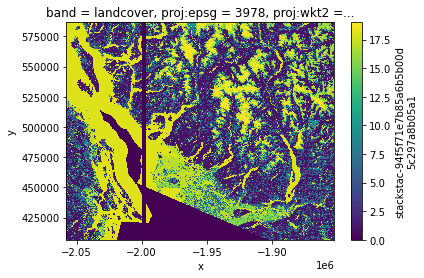

In [13]:
merged.plot()
plt.show()

It looks good, but it doesn't look like a land cover map. The source GeoTIFFs contain a colormap and the STAC metadata contains the class names. We'll open one of the source files just to read this metadata and construct the right colors and names for our plot.

In [108]:
# Replace nodata values with np.nan
merged = merged.where(merged != nodata)

# Create a list of class names indexed according to the landcover values
file_values = {
    d["values"][0]: d["summary"] for d in items[0]["assets"]["landcover"]["file:values"]
}
max_value = int(max(file_values.keys()) + 1)
class_names = [
    f"{i}: {file_values.get(value, 'Empty class')}"
    for i, value in enumerate(range(max_value))
]

# Create color map for plotting
with rasterio.open(pc.sign(item.assets["landcover"].href)) as src:
    colormap = src.colormap(1)  # get metadata colormap for band 1
    colors_rgb = [c for i, c in colormap.items() if i < max_value]
    colors_rgb[0] = [
        0,
        0,
        0,
        255,
    ]  # change first color so it doesn't conflict with snow & ice
    colors_mpl = [
        np.array(colors_rgb[i]) / 255 for i in range(len(colors_rgb))
    ]  # transform to matplotlib color format
cmap = ListedColormap(colors_mpl)

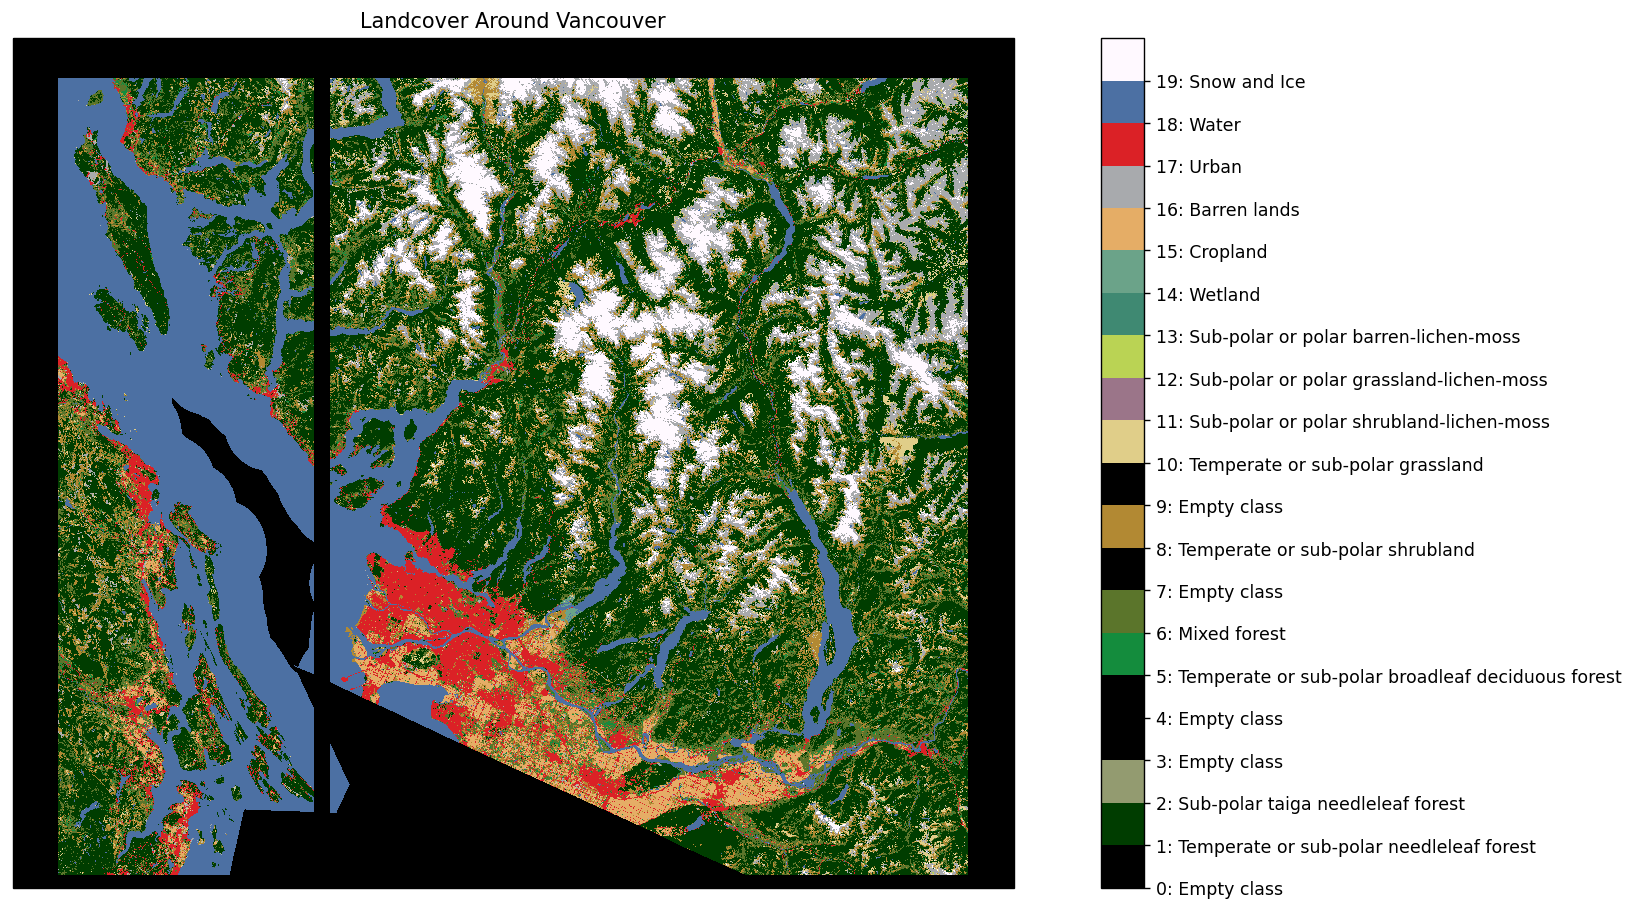

In [109]:
fig, ax = plt.subplots(
    figsize=(18, 9), dpi=125, subplot_kw=dict(projection=ccrs.epsg(epsg)), frameon=False
)
p = merged.plot(
    ax=ax,
    transform=ccrs.epsg(epsg),
    cmap=cmap,
    add_colorbar=False,
    vmin=0,
    vmax=max_value,
)
ax.set_title("Landcover Around Vancouver")
ax.set_facecolor("k")

cbar = plt.colorbar(p)
cbar.set_ticks(range(max_value))
cbar.set_ticklabels(class_names)

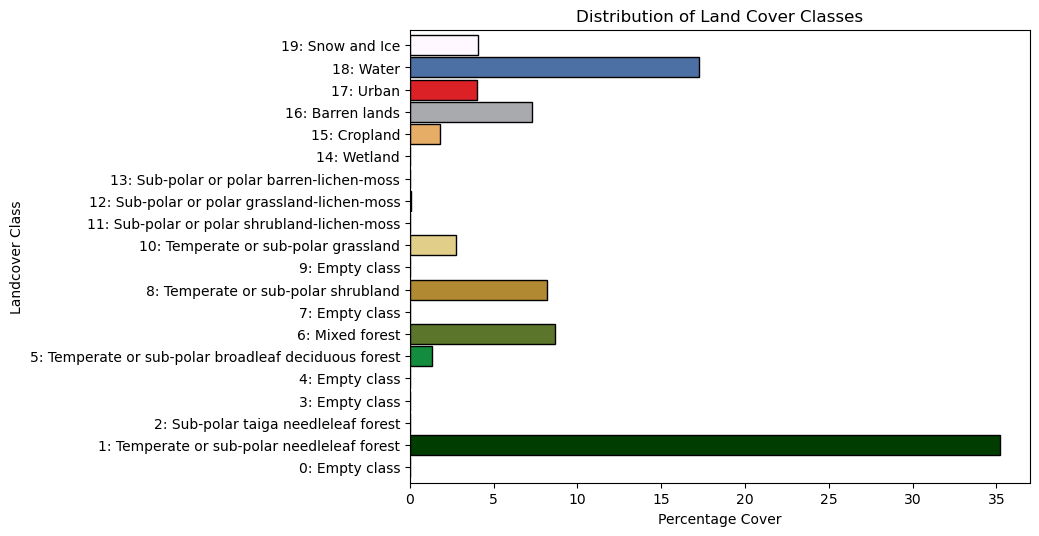

In [124]:
ax = plt.figure(figsize=(8, 6), dpi=100).gca()

colors = list(cmap.colors)

df = (
    pd.value_counts(merged.data.ravel(), sort=False)
    .divide(merged.shape[0] * merged.shape[1] / 100)
    .sort_index()
    .reindex(range(len(colors)), fill_value=0)
    .rename(dict(enumerate(class_names)))
)
df.plot.barh(ax=ax, color=colors, rot=0, width=0.9, linewidth=1, edgecolor="black")

ax.set(
    title="Distribution of Land Cover Classes",
    ylabel="Landcover Class",
    xlabel="Percentage Cover",
    facecolor="white",
);